    Imports

In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
import numpy as np 
from scipy.stats import norm

    Detection of GPUs

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# PINNs for Black-Scholes Pricing in One Dimension

The Physics Informed Neural Networks (PINNs) are a type of neural network that leverage the underlying physics of the problem at hand. In the case of option pricing using the Black-Scholes model, the underlying physics is the Black-Scholes Partial Differential Equation (PDE).

## Input Variables

The Black-Scholes PDE takes two variables as input:
1. t: The time to maturity of the option. This is a temporal variable.
2. S: The price of the underlying asset. This is a spatial variable.

## Neural Network Definition

The BlackScholesNN class defines the neural network. It inherits from the nn.Module class of PyTorch. The network is a simple feed-forward network with one hidden layer of 50 neurons and a Tanh activation function. The input layer has 2 neurons (corresponding to t and S) and the output layer has 1 neuron (corresponding to the option price V).
The forward method defines how the network processes the inputs. It concatenates t and S, and passes them through the network to compute V.

In [3]:
class BlackScholesNN(nn.Module):
    def __init__(self):
        super(BlackScholesNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        )

    def forward(self, t, S):
        inputs = torch.cat([t, S], dim=1)
        return self.net(inputs)

In [4]:
model = BlackScholesNN().to(device)
optimizer = Adam(model.parameters(), lr=0.001)

## Black-Scholes Model Parameters

First, we define the parameters of the Black-Scholes model:
- r: the risk-free interest rate
- sigma: the volatility of the underlying asset
- K: the strike price of the option
- T: the maturity of the option

Next, we create a time grid t and a price grid S for the underlying asset. These grids are used to calculate the option price at different times and for different values of the underlying asset.

In [5]:
# Black-Scholes model parameters
r = torch.tensor(0.05, device=device)  # Risk-free interest rate
sigma = torch.tensor(0.2, device=device)  # Volatility
K = torch.tensor(100, device=device)  # Strike price
T = torch.tensor(2, device=device)  # Maturity

# Time and asset price grid
t = torch.linspace(0, T, 100, device=device).view(-1, 1)
S = torch.linspace(20, 200, 100, device=device).view(-1, 1)
t, S = torch.meshgrid(t[:, 0], S[:, 0], indexing='ij')
t, S = t.reshape(-1, 1), S.reshape(-1, 1)

## The Black-Scholes EDP for pricing a call option is as follows:

$$
\frac{\partial C}{\partial t} + \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 C}{\partial S^2} + r S \frac{\partial C}{\partial S} - r C = 0
$$

where:

- \( C \) is the price of the call option.
- \( t \) is the time.
- \( S \) is the price of the underlying asset.
- \( sigma \) is the volatility of the underlying asset.
- \( r \) is the risk-free interest rate.


## Training the Network

We declare that the variables t and S require gradient computation. This allows PyTorch to automatically compute the derivatives of these variables during backpropagation.
We initialize a training loss record train_loss_record and define the number of training epochs n_epochs.
For each epoch, we perform the following steps:
1. We reset the network gradients with optimizer.zero_grad().
2. We pass t and S through the network to get the option price V.
3. We compute the derivatives of V with respect to t and S (V_t and V_s), as well as the second derivative of V with respect to S.
4. We compute the function f which represents the left-hand side of the Black-Scholes partial differential equation.
5. We compute the loss as the mean of the square of f.
6. We add a terminal condition to the loss to penalize deviations between the option price predicted by the network and the option payoff when t is close to T.
7. We add the value of the loss to train_loss_record.
We perform a backpropagation to compute the gradients of the loss with respect to the network parameters.
9. We update the network parameters with optimizer.step().
10. Every 500 epochs, we print the current epoch and the value of the loss.

In [6]:
# Variables t and S must be declared for gradient computation
t.requires_grad = True
S.requires_grad = True

train_loss_record = []

n_epochs=10001

for epoch in range(n_epochs):
    optimizer.zero_grad()
    V = model(t, S)
    V_t = torch.autograd.grad(V, t, torch.ones_like(V, device=device), create_graph=True)[0]
    V_s = torch.autograd.grad(V, S, torch.ones_like(V, device=device), create_graph=True)[0]
    V_ss = torch.autograd.grad(V_s, S, torch.ones_like(V_s, device=device), create_graph=True)[0]

    # Black-Scholes PDE
    f = V_t + 0.5 * sigma**2 * S**2 * V_ss + r * S * V_s - r * V
    loss = torch.mean(f ** 2)

    # Adding terminal condition for t close to T
    payoff = torch.maximum(S - K, torch.zeros_like(S, device=device))
    terminal_condition = (t >= 0.95 * T) * (V - payoff) ** 2  # Penalizes deviations at T
    loss += torch.mean(terminal_condition)

    train_loss_record.append(loss.detach().cpu().numpy())

    loss.backward()
    optimizer.step()
    
    if epoch % 500 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 95.27501678466797
Epoch 500, Loss: 51.71763610839844
Epoch 1000, Loss: 28.7305850982666
Epoch 1500, Loss: 15.790013313293457
Epoch 2000, Loss: 8.861989974975586
Epoch 2500, Loss: 5.041537761688232
Epoch 3000, Loss: 2.913257122039795
Epoch 3500, Loss: 1.723082184791565
Epoch 4000, Loss: 1.061507225036621
Epoch 4500, Loss: 0.703609049320221
Epoch 5000, Loss: 0.5090012550354004
Epoch 5500, Loss: 0.3919786810874939
Epoch 6000, Loss: 0.3394121825695038
Epoch 6500, Loss: 0.2675561308860779
Epoch 7000, Loss: 0.23296332359313965
Epoch 7500, Loss: 0.20751158893108368
Epoch 8000, Loss: 0.1894659698009491
Epoch 8500, Loss: 0.17535951733589172
Epoch 9000, Loss: 0.1649424433708191
Epoch 9500, Loss: 0.15803901851177216
Epoch 10000, Loss: 0.15350571274757385


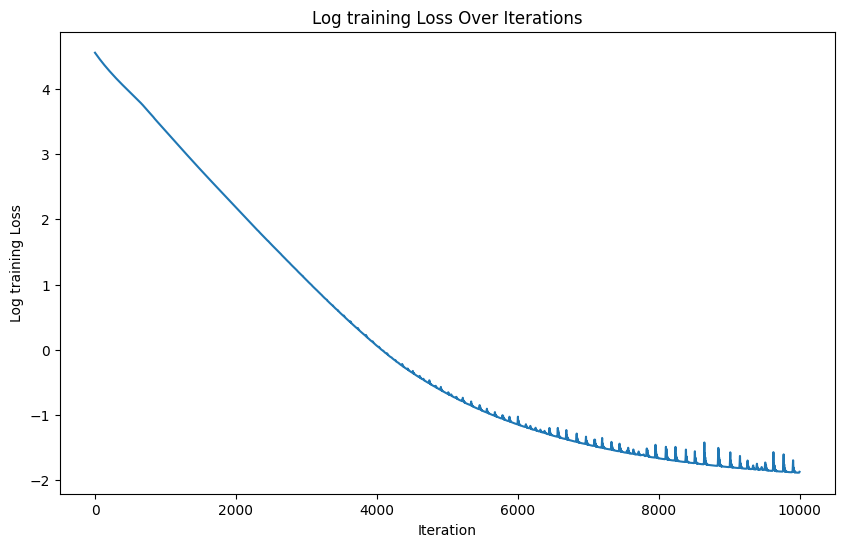

In [7]:
# Display the evolution of training loss
plt.figure(figsize=(10, 6))
plt.plot(np.log(train_loss_record))
plt.title("Log training Loss Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Log training Loss")
plt.show()

## Predicting Option Prices

Once the network is trained, it can predict the price of an option for any given t and S. This is done by passing t and S through the network and returning the output V. The network's ability to accurately price options can be visualized by plotting V as a function of t and S.

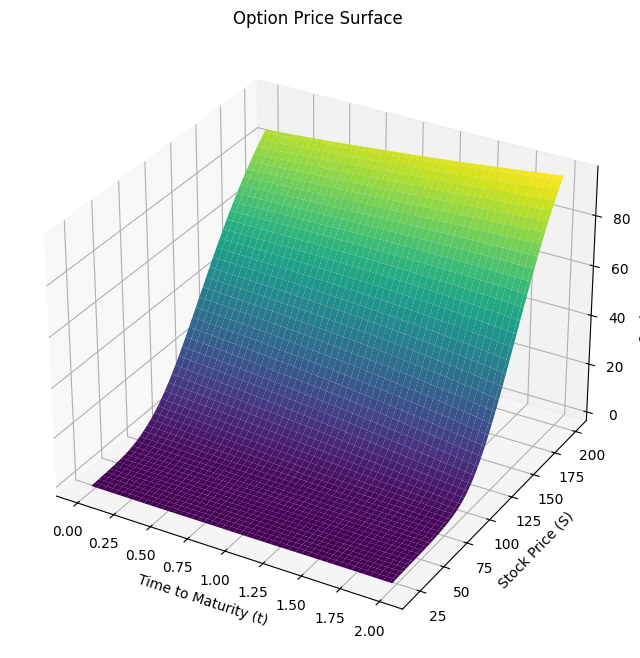

In [8]:
# Define a grid of values for t and S
t_vals = torch.linspace(0, T, 100, device=device).view(-1, 1)
S_vals = torch.linspace(20, 200, 100, device=device).view(-1, 1)
t_grid, S_grid = torch.meshgrid(t_vals[:, 0], S_vals[:, 0], indexing='ij')
t_grid = t_grid.reshape(-1, 1)
S_grid = S_grid.reshape(-1, 1)

# Predict option prices
with torch.no_grad(): 
    V_pred = model(t_grid, S_grid).cpu().reshape(100, 100)

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
t_plot, S_plot = t_grid.cpu().reshape(100, 100), S_grid.cpu().reshape(100, 100)
ax.plot_surface(t_plot.numpy(), S_plot.numpy(), V_pred.numpy(), cmap='viridis')

ax.set_xlabel('Time to Maturity (t)')
ax.set_ylabel('Stock Price (S)')
ax.set_zlabel('Option Price (V)')
ax.set_title('Option Price Surface')
plt.show()

In [9]:
# Define fixed inputs
t_fixed = torch.tensor([[0.0]], device=device)  # Time to maturity
S_fixed = torch.tensor([[100]], device=device)  # Stock price

# Predict the call option price
with torch.no_grad(): 
    V_pred = model(t_fixed, S_fixed)

print(f'The predicted price for the call option is: {V_pred.item()}')

The predicted price for the call option is: 16.43414306640625


In [10]:
def black_scholes_call(S0, K, r, sigma, T):
    """
    Calculates the price of a European call option using the Black-Scholes formula.

    Parameters:
    S0 (float): The current price of the underlying asset.
    K (float): The strike price of the option.
    r (float): The risk-free interest rate.
    sigma (float): The volatility of the underlying asset.
    T (float): The time to expiration of the option.

    Returns:
    float: The price of the call option.

    """
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = (S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2))
    
    return call_price

In [11]:
black_scholes_call(100, 100, 0.05, 0.2, 2)

16.126779724978633